# Dataset Inspection and Dimensionality Reduction with PCA

The goal of this notebook is to inspect, process and standarize PAVI dataset. Afterwards, apply PCA for each region and compare the results with an average PCA (with reshaped theta_s)

## Workflow

1. Standarize for each region
2. PCA for each region
3. Fit model (Not on this notebook)

## Understanding the fundamentals clearly

### Normalization within Each Fold During Cross-Validation and Feature Selection
- Definition: Normalization (or standardization) involves rescaling the features of data so that they have a mean of zero and a standard deviation of one.
- Within Each Fold: When performing cross-validation, you must normalize the training and validation data within each fold separately. This means that for each fold:
    - Compute the normalization parameters (mean and standard deviation) using only the training data of that fold.
    - Apply this normalization to both the training and validation sets of that fold.

Why Normalization within Each Fold is Important? Applying normalization to the entire dataset before cross-validation causes the validation data to influence the normalization parameters. This is a form of data leakage and leads to an over-optimistic evaluation of the model's performance (Over-fitting).

*Feature Selection Before Cross-Validation is a Big NO:*

Feature selection involves selecting the most relevant features from the dataset before training the model.
Why It's Problematic?
1. Data Leakage: If you perform feature selection on the entire dataset before cross-validation, information from the validation set leaks into the training process. This can result in the model performing better during cross-validation than it would on truly unseen data.
2. Overfitting: By selecting features based on the entire dataset, the selected features are biased by the validation data. This can lead to overfitting, where the model captures noise and specific patterns from the validation data that do not generalize to new, unseen data.

Where are going to standarize the data for each region on this dataset and treating them as a independent dimensions.

### Normalizing Data Before Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms the data into a set of orthogonal components that capture the maximum variance in the data. 

Why Normalize:
1. Equal Importance: Different features can have different units and scales (e.g., height in meters and weight in kilograms). PCA is sensitive to the variances of the features, so features with larger scales will dominate the principal components.
2. Fair Comparison: Normalizing the data ensures that each feature contributes equally to the analysis, allowing PCA to capture the true underlying structure of the data.

Importance of Normalizing Data Before PCA:
- Avoid Bias: Without normalization, PCA may attribute more importance to features with larger scales, leading to biased principal components that do not reflect the true variance structure of the data.
- Effective Dimensionality Reduction: Normalized data allows PCA to identify the directions of maximum variance more accurately, resulting in more meaningful and effective dimensionality reduction.


In [6]:
import sys
import json
import pickle
from tqdm import tqdm
from pathlib import Path
import random

import torch
import numpy as np
import pandas as pd

from scipy.special import softmax

import pyro.distributions as dist

import os

sys.path.append("/home/mind/jrobador/pavi_pytorch/")
from utils.dataset import HCPDataLoader, HCPDataset
from utils.config import PATH_TEMPLATE_FULL, SUBJECTS_LIST
from utils.downstream import ScoresPredictionTask

# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device('cpu')

file_path = os.path.join('/home/mind/jrobador/3_camcan', f'12_mean_sample_post.pt')
sample = torch.load(file_path, map_location=DEVICE)

In [7]:
import json
import os

def load_json(filename):
    """Load JSON data from a file."""
    if not os.path.isfile(filename):
        raise FileNotFoundError(f"The file {filename} does not exist.")
    
    with open(filename, 'r', encoding='utf-8') as file:
        try:
            data = json.load(file)
        except json.JSONDecodeError as e:
            raise ValueError(f"Error decoding JSON: {e}")
    return data

def inspect_json(data, level=0):
    """Recursively inspect the JSON data and print its structure."""
    indent = '  ' * level
    if isinstance(data, dict):
        print(f"{indent}Object:")
        for key, value in data.items():
            print(f"{indent}  Key: '{key}'")
            inspect_json(value, level + 1)
    elif isinstance(data, list):
        print(f"{indent}Array:")
        for index, item in enumerate(data):
            print(f"{indent}  Index {index}:")
            inspect_json(item, level + 1)
    elif isinstance(data, str):
        print(f"{indent}String: '{data}'")
    elif isinstance(data, (int, float)):
        print(f"{indent}Number: {data}")
    elif isinstance(data, bool):
        print(f"{indent}Boolean: {data}")
    elif data is None:
        print(f"{indent}Null")
    else:
        print(f"{indent}Unknown type: {data}")

def print_summary(data):
    """Print a summary of the JSON data."""
    print("\nJSON File Summary:")
    if isinstance(data, dict):
        print(f"Root element is an Object with {len(data)} keys.")
    elif isinstance(data, list):
        print(f"Root element is an Array with {len(data)} items.")
    else:
        print(f"Root element is of type: {type(data).__name__}")


try:
    json_data = load_json('/home/mind/jrobador/3_camcan/jobs.json')
except Exception as e:
    print(f"An error occurred: {e}")

print("JSON Data:")
print(json.dumps(json_data, indent=2))  # Print the raw JSON data with indentation

print_summary(json_data)
inspect_json(json_data)

JSON Data:
{
  "sub_list": [
    [
      "CC221775",
      "CC510208",
      "CC610046",
      "CC722891",
      "CC712027",
      "CC122405",
      "CC620354",
      "CC510609",
      "CC121200",
      "CC610292",
      "CC320478",
      "CC610099",
      "CC620359",
      "CC721891",
      "CC121428",
      "CC410220",
      "CC120550",
      "CC520607",
      "CC221244",
      "CC222120",
      "CC520552",
      "CC520624",
      "CC620164",
      "CC320904",
      "CC110056",
      "CC420149",
      "CC710214",
      "CC321107",
      "CC610344",
      "CC520011",
      "CC320651",
      "CC312058",
      "CC220974",
      "CC621642",
      "CC221324",
      "CC510304",
      "CC510226",
      "CC520211",
      "CC121144",
      "CC621199",
      "CC610508",
      "CC220223",
      "CC610061",
      "CC310008",
      "CC610050",
      "CC221886",
      "CC721504",
      "CC310142"
    ],
    [
      "CC620405",
      "CC310008",
      "CC710446",
      "CC520517",
      "CC610576",

In [8]:
categories = [
    'BentonFaces_total',
    'Cattell_total',
    'EkmanEmHex_pca1',
    'FamousFaces_details',
    'Hotel_time',
    'PicturePriming_baseline_acc',
    'Proverbs',
    'Synsem_prop_error',
    'Synsem_RT',
    'VSTMcolour_K_mean',
    'VSTMcolour_K_precision',
    'VSTMcolour_K_doubt',
    'VSTMcolour_MSE'
]
n_job = 44
with open('/home/mind/jrobador/3_camcan/jobs.json', 'r') as f:
    jobs = json.load(f)
seed = jobs['seed'][n_job]
print (seed)

subjects_list = jobs['sub_list'][n_job]
print(type(subjects_list))

n_subjects = len(subjects_list)
print(n_subjects)

from typing import Optional, List, Union, Dict, Iterable
if isinstance(subjects_list, Iterable):
    subjects_list = np.array([str(s) for s in subjects_list])




42
<class 'list'>
240


In [9]:
n_scores = len(categories)
print (n_scores)

13


In [10]:
epoch_checkpoint = 12
file_path = os.path.join('/home/mind/jrobador/3_camcan', f'{epoch_checkpoint}_mean_sample_post.pt')
sample = torch.load(file_path, map_location=DEVICE)
for key, _ in sample.items():
    print(f" {key}")

 mu_g
 epsilon
 sigma
 mu_s
 mu_st
 kappa
 gamma
 theta
 theta_s


In [11]:
theta_s = sample['theta_s']
print (theta_s.shape)

theta_s_reshaped = theta_s.reshape((n_subjects, -1))
print (theta_s_reshaped.shape)

torch.Size([240, 59412, 17])
torch.Size([240, 1010004])


In [12]:
print(theta_s)

tensor([[[ 1.5495e+00, -4.1696e-01, -9.4875e-02,  ..., -1.0502e+00,
          -4.7919e-02, -1.1361e+00],
         [-2.4477e+00,  2.1368e+00, -8.3218e-01,  ...,  2.2424e+00,
           1.8604e-01, -6.7584e-01],
         [-7.4951e-01,  8.8324e-01, -1.2285e+00,  ...,  3.5631e-01,
          -9.4691e-01, -1.7898e+00],
         ...,
         [-1.4503e-01, -1.1155e+00,  4.6978e+00,  ..., -1.9716e+00,
          -1.0875e+00, -9.6098e-01],
         [-5.5818e-01, -1.1412e-01,  2.5718e+00,  ...,  2.4093e-01,
          -8.8962e-01, -1.2459e+00],
         [-7.2123e-02,  6.2495e-01,  1.2730e+00,  ...,  2.1179e+00,
          -2.2742e-01, -5.5707e-01]],

        [[ 5.4057e+00, -1.3629e+00,  1.0039e+00,  ..., -8.4212e-01,
          -9.9581e-01, -4.2592e-01],
         [-1.1428e+00,  1.9199e+00, -1.0266e+00,  ...,  9.8412e-01,
           7.2713e-01, -3.4070e-01],
         [ 4.1898e-01, -6.9682e-02, -2.5492e+00,  ...,  5.3029e-01,
           2.9758e+00,  7.2810e-01],
         ...,
         [ 2.7487e+00, -9

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [14]:
path_scores=Path('/home/mind/jrobador/3_camcan/scores_camcan.csv')

def load_csv(filename):
    """Load CSV data from a file."""
    if not os.path.isfile(filename):
        raise FileNotFoundError(f"The file {filename} does not exist.")
    
    try:
        data = pd.read_csv(filename)
    except Exception as e:
        raise ValueError(f"Error reading CSV file: {e}")
    return data

def inspect_csv(data):
    """Inspect the CSV data and print its structure and summary."""
    print("CSV Data Preview:")
    print(data.head())  # Print the first 5 rows of the data
    
    print("\nData Summary:")
    print(data.info())  # Print a concise summary of the DataFrame
    
    print("\nSummary Statistics for Numerical Columns:")
    print(data.describe())  # Print summary statistics for numerical columns
    
    print("\nMissing Values in Each Column:")
    print(data.isnull().sum())  # Print the number of missing values in each column

csv_data = load_csv(path_scores)
inspect_csv(csv_data)

CSV Data Preview:
   Unnamed: 0   Subject  BentonFaces_total  CardioMeasures_pulse_mean  \
0           0  CC711182                NaN                        NaN   
1           1  CC224337                NaN                        NaN   
2           2  CC120410                NaN                        NaN   
3           3  CC610119                NaN                        NaN   
4           4  CC610581                NaN                        NaN   

   CardioMeasures_bp_sys_mean  CardioMeasures_bp_dia_mean  Cattell_total  \
0                         NaN                         NaN            NaN   
1                         NaN                         NaN            NaN   
2                         NaN                         NaN            NaN   
3                         NaN                         NaN            NaN   
4                         NaN                         NaN            NaN   

   EkmanEmHex_pca1  EkmanEmHex_pca1_expv  \
0              NaN              0.657152  

In [15]:
scaler = StandardScaler()    
def _preprocess_scores(data):
    data.Subject = data.Subject.astype('str')
    
    # Discard subjects with Nan-valued scores or subjects not in the list
    mask = data[categories].isna().sum(axis=1) == 0
    id_subjects_ok = set(data[mask].Subject) & set(subjects_list)

    mask = data.Subject.isin(id_subjects_ok)
    data = data[mask][categories + ['Subject']]
    data = data.set_index('Subject')

    scaler = StandardScaler()
    data = pd.DataFrame(
        data=scaler.fit_transform(data),
        columns=data.columns,
        index=data.index
    )

    mask = pd.Series(subjects_list).isin(id_subjects_ok).to_numpy()
    return data.loc[subjects_list[mask]], mask


scores = pd.read_csv(path_scores)
scores_2, mask = _preprocess_scores(scores)
y = scores_2.to_numpy()



In [24]:
X = theta_s
X = np.array([x.cpu().numpy() for x in X])[mask]
print(X.shape)

(218, 59412, 17)


In [ ]:
print (f"{y.mean()=}, {y.std()=}")
print (X.mean(), X.std())   # X DATA IS NOT STANDARIZED BUT Y IS!!


-1.7049014125506992e-16 1.0


In [63]:
def standardize_x_per_region(X_train, X_test):
    n_dimensions = 17
    scalers = [StandardScaler() for _ in range(n_dimensions)]
    X_train_scaled = np.empty_like(X_train)
    X_test_scaled = np.empty_like(X_test)

    for i in range(n_dimensions):
        X_train_dim = X_train[:, :, i]
        X_test_dim = X_test[:, :, i]

        scaler = scalers[i]
        X_train_scaled_dim = scaler.fit_transform(X_train_dim)
        X_test_scaled_dim = scaler.transform(X_test_dim)

        X_train_scaled[:, :, i] = X_train_scaled_dim
        X_test_scaled[:, :, i] = X_test_scaled_dim
    
    return X_train_scaled, X_test_scaled

In [64]:
import matplotlib.pyplot as plt

def plot_explained_variance_per_region(pca_models):
    
    # Extract explained variance ratios from the fitted PCA models
    explained_variance_ratios = [pca.explained_variance_ratio_ for pca in pca_models]

    # Plot explained variance ratios for each dimension
    plt.figure(figsize=(14, 8))

    for i, var_ratio in enumerate(explained_variance_ratios):
        plt.plot(np.arange(1, len(var_ratio) + 1), var_ratio, label=f'Dimension {i + 1}')

    plt.xlabel('PCA Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio by PCA Components for Each Dimension')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()

    plt.figure(figsize=(14, 10))
    for i, var_ratio in enumerate(explained_variance_ratios):
        plt.plot(np.arange(1, len(var_ratio) + 1), var_ratio, label=f'Dimension {i + 1}')
        plt.xlabel('PCA Components')
        plt.ylabel('Explained Variance Ratio')
        plt.title(f'Explained Variance Ratio for Dimension {i + 1}')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        
    cumulative_variance_ratios = [np.cumsum(ratio) for ratio in explained_variance_ratios]

    # Plot cumulative explained variance ratios for all dimensions combined
    plt.close()
    plt.figure(figsize=(14, 8))
    for i in range(17):
        plt.plot(np.arange(1, len(cumulative_variance_ratios[i]) + 1), cumulative_variance_ratios[i], label=f'Dimension {i + 1}')
    
    plt.xlabel('PCA Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Cumulative Explained Variance Ratio by PCA Components for Each Dimension')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()

In [65]:
def pca_per_region(X_train, X_test, n_components):
    pca_models = [PCA(n_components=n_components) for _ in range(17)]
    X_train_pca = []
    X_test_pca = []

    for i in range(17):
        X_train_dim = X_train[:, :, i]
        X_test_dim = X_test[:, :, i]

        X_train_pca_dim = pca_models[i].fit_transform(X_train_dim)
        X_test_pca_dim = pca_models[i].transform(X_test_dim)

        X_train_pca.append(X_train_pca_dim)
        X_test_pca.append(X_test_pca_dim)
    
    X_train_pca = np.concatenate(X_train_pca, axis=1)
    X_test_pca = np.concatenate(X_test_pca, axis=1)

    return X_train_pca, X_test_pca, pca_models
    

In [66]:
from joblib import Parallel, delayed
from tqdm import tqdm

def inner_loop(train_idx, test_idx):
    
    scores_ = np.full((n_scores,), np.nan)
    mape_scores = np.full((n_scores,), np.nan)

    X_train = X[train_idx]
    X_test = X[test_idx]

    print (f"{X_train.shape=}")
    X_train_scaled, X_test_scaled = standardize_x_per_region(X_train, X_test)
    print (f"{X_train_scaled.shape=}")
    X_train_pca, X_test_pca, pca_models = pca_per_region(X_train_scaled, X_test_scaled, 190)

    print (f"X Dimension after PCA train:{X_train_pca.shape}")
    print (f"X Dimension after PCA test:{X_test_pca.shape}")

    plot_explained_variance_per_region(pca_models)
    


#    mean_X_train = np.mean(X_train)
#    std_X_train = np.std(X_train)
#    mean_X_test = np.mean(X_test)
#    std_X_test = np.std(X_test)
#    mean_y_train = np.mean(y[train_idx])
#    std_y_train = np.std(y[train_idx])
#    mean_y_test = np.mean(y[test_idx])
#    std_y_test = np.std(y[test_idx])
#
#    # Print mean and standard deviation
#    print(f"Mean of X_train: {mean_X_train:.4f}")
#    print(f"Standard deviation of X_train: {std_X_train:.4f}")
#
#    print(f"Mean of y[train_idx]: {mean_y_train:.4f}")
#    print(f"Standard deviation of y[train_idx]: {std_y_train:.4f}")
#
#    print(f"Mean of X_test: {mean_X_test:.4f}")
#    print(f"Standard deviation of X_test: {std_X_test:.4f}")
#
#    print(f"Mean of y[test_idx]: {mean_y_test:.4f}")
#    print(f"Standard deviation of y[test_idx]: {std_y_test:.4f}")

    
    # input_dim = X_train.shape[1]                
    # output_dim = y[train_idx].shape[0] if len(y[train_idx].shape) == 1 else y[train_idx].shape[1]
    # print(f"{input_dim=}, {output_dim=}")
    # alpha = 1

X_train.shape=(196, 59412, 17)
X_train_scaled.shape=(196, 59412, 17)
X Dimension after PCA train:(196, 3230)
X Dimension after PCA test:(22, 3230)


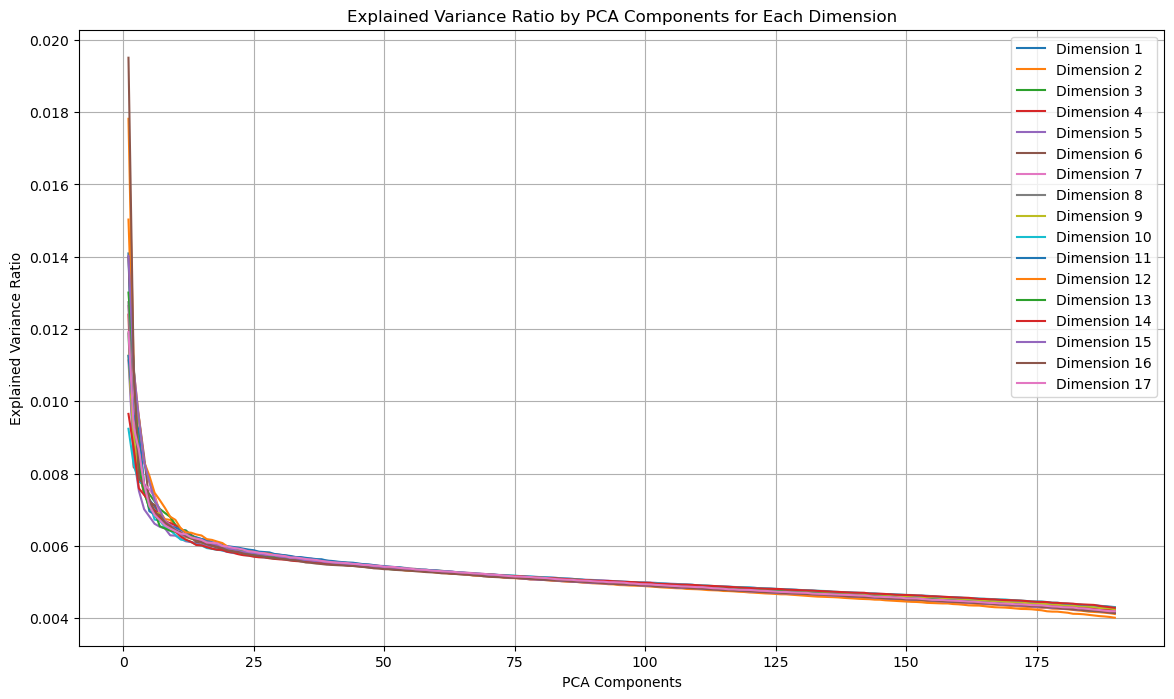

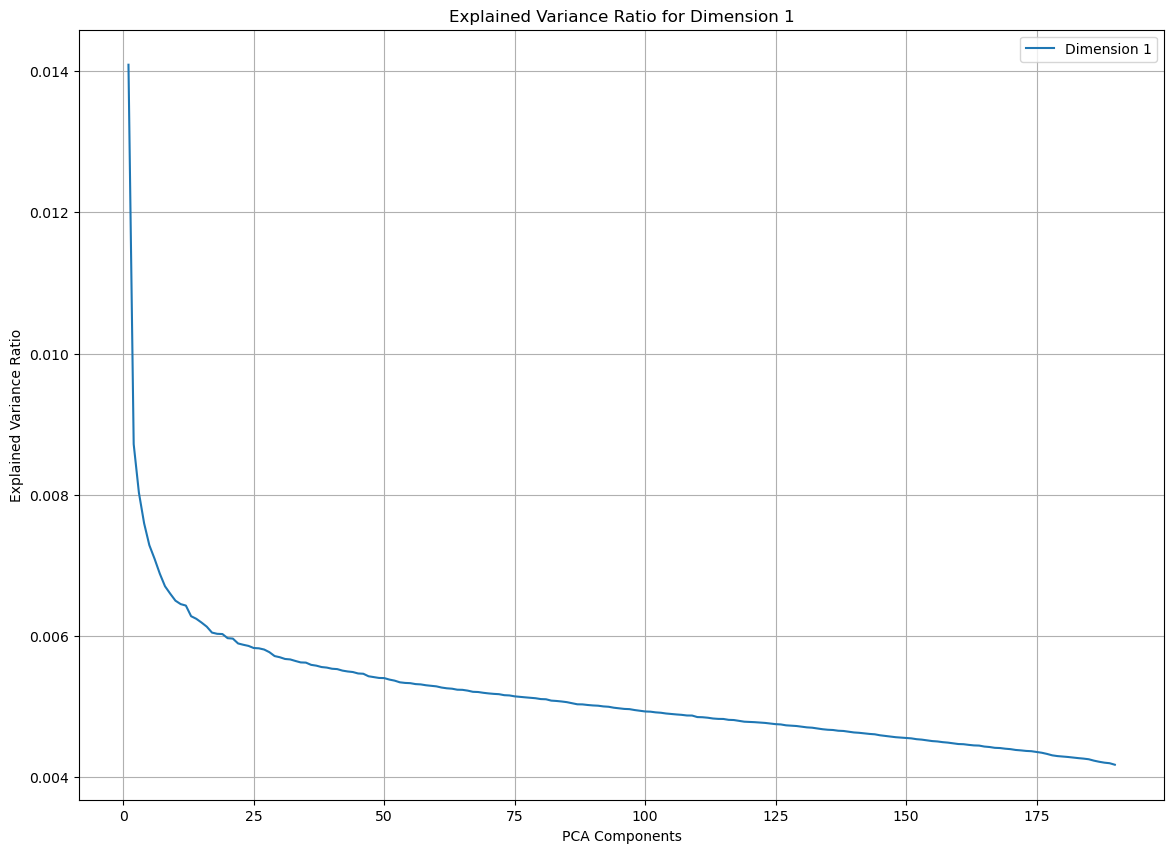

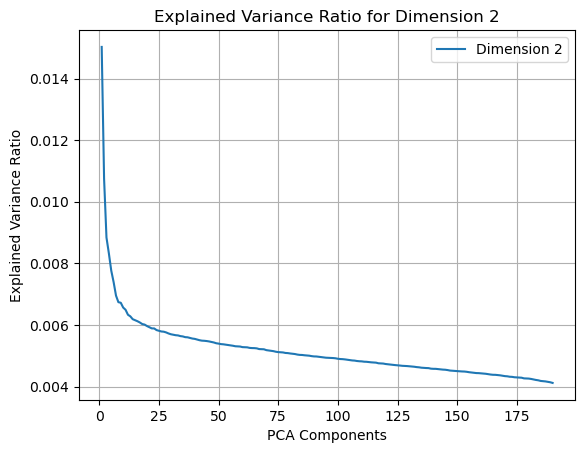

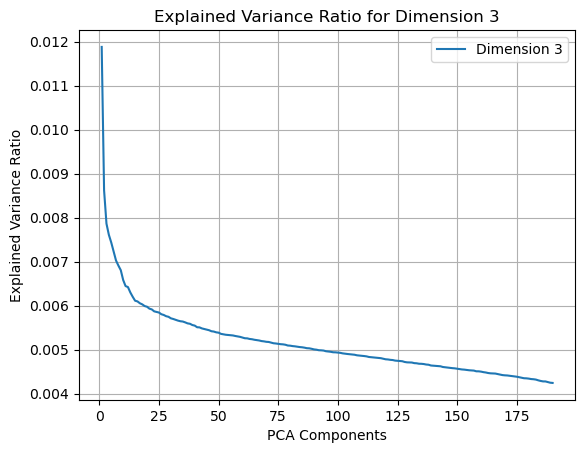

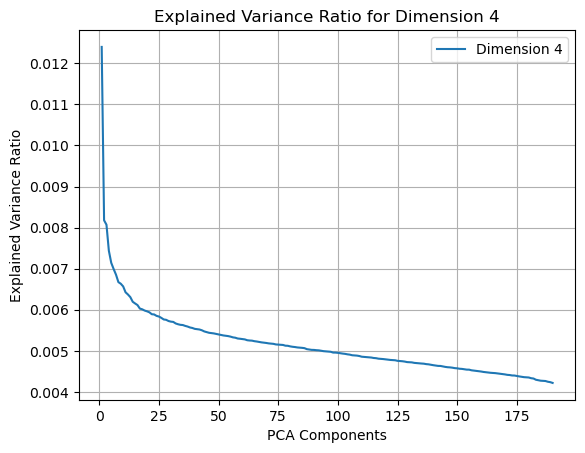

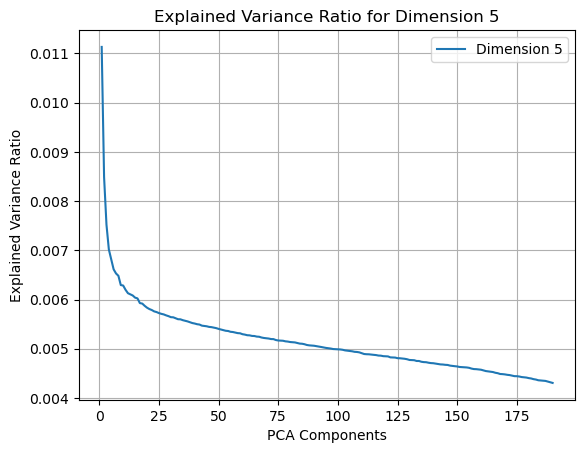

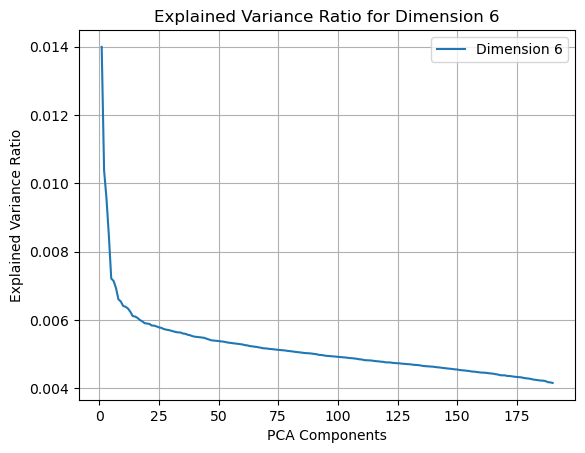

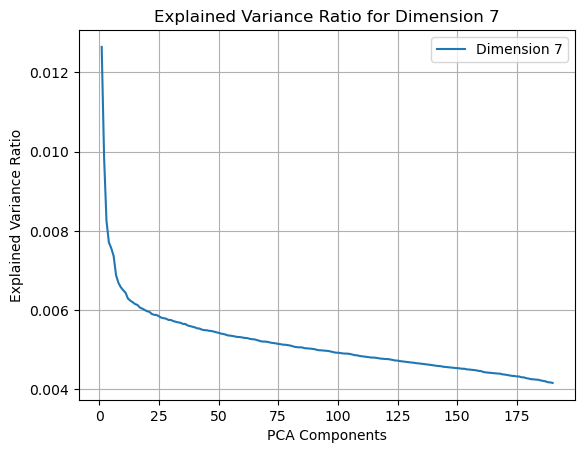

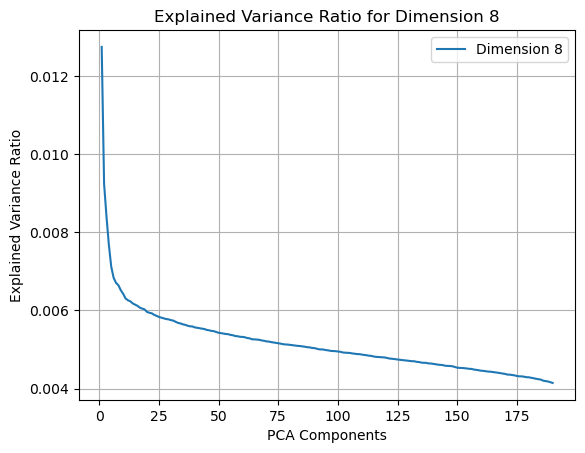

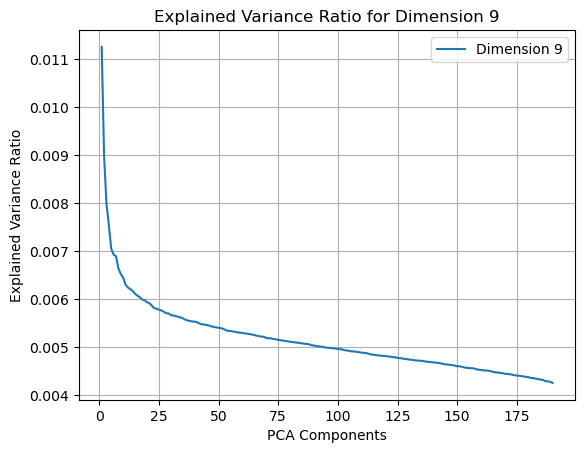

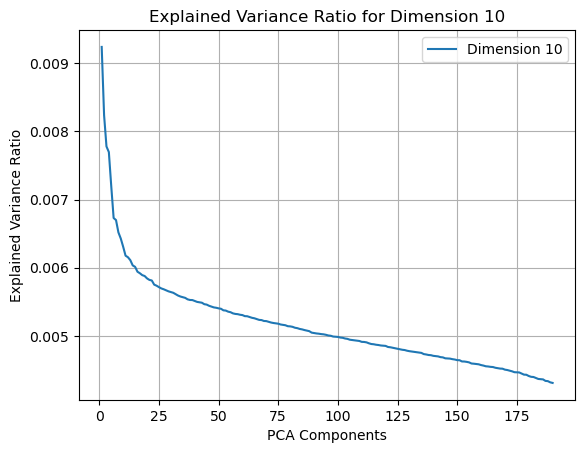

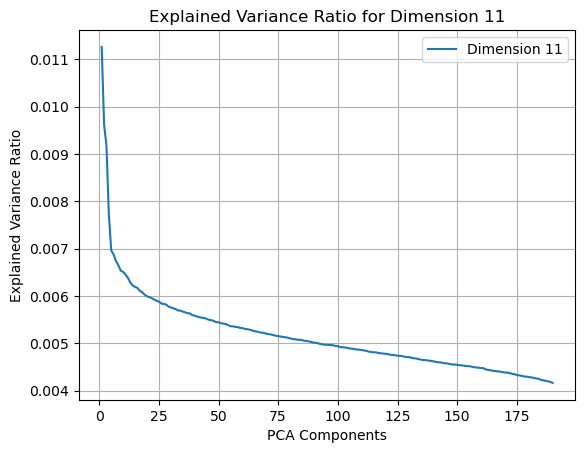

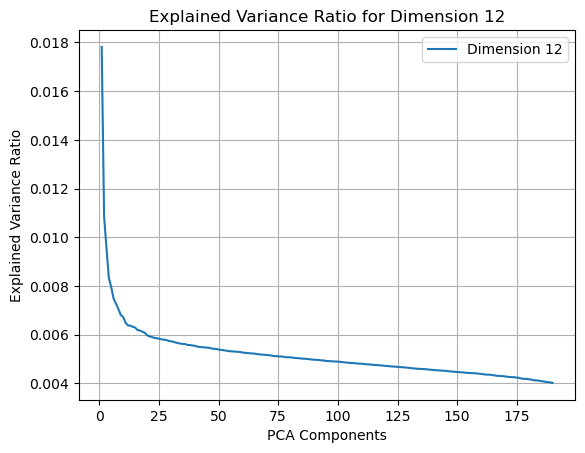

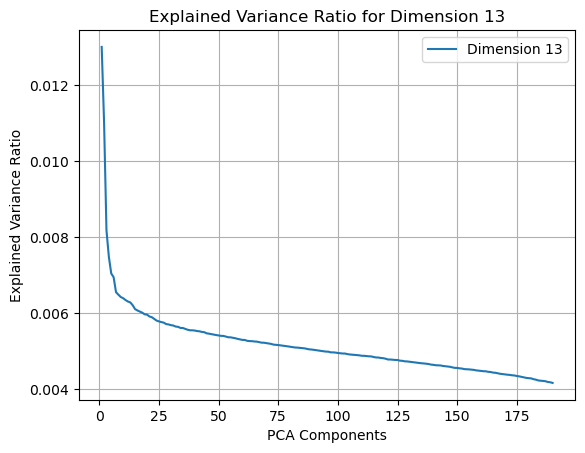

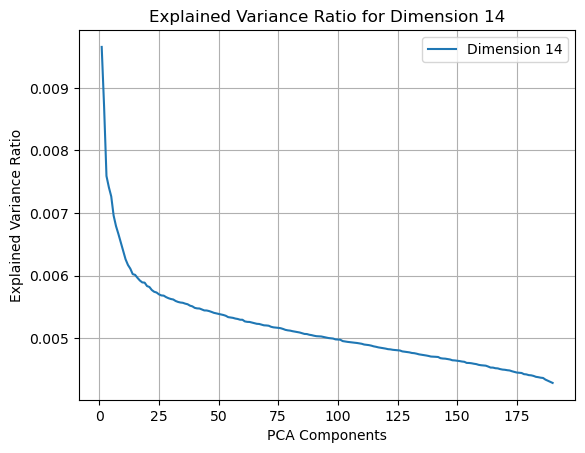

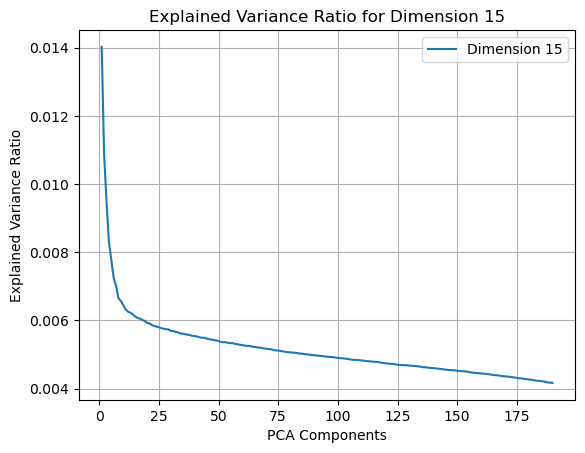

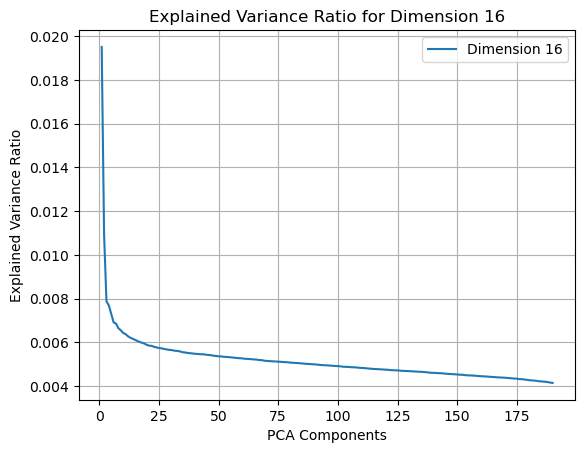

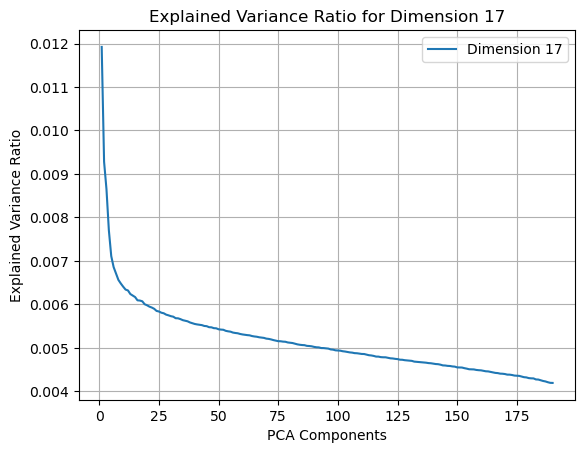

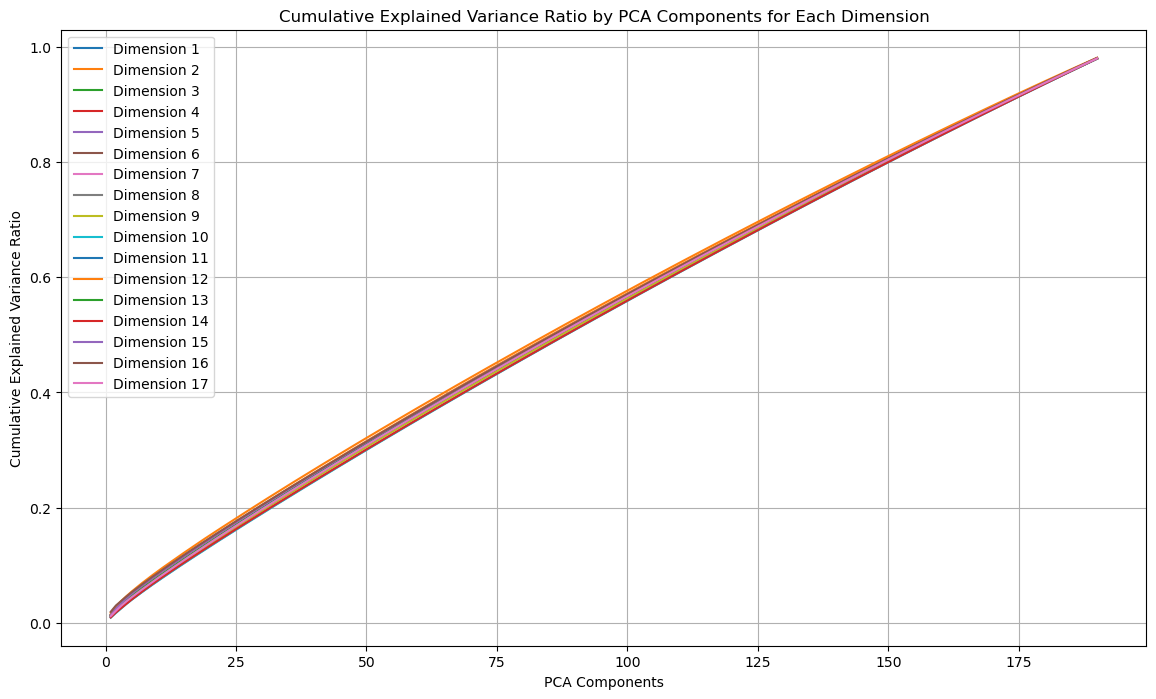

X_train.shape=(196, 59412, 17)


KeyboardInterrupt: 

In [67]:
from sklearn.model_selection import RepeatedKFold


n_splits = 10
n_repeats = 1
random_state = 42
n_jobs = 1  # Number of parallel jobs

kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

scores_list = Parallel(n_jobs=n_jobs)(
    delayed(inner_loop)(train_idx, test_idx)
    for train_idx, test_idx in tqdm(kf.split(X))
)